In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams.update({'font.size': 20})
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

# Load functional data

In [51]:
file = os.path.join(root_directory,'fly_21','func_0','motcorr','motcorr_red.nii')
data = bbb.load_numpy_brain(file)
data.shape


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 10.59 sec


(128, 79, 53, 4370)

# Or, reconstruct from PCs

In [85]:
t0 = time.time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
pca_spatial.shape = (pca_spatial.shape[0], -1)
pca_spatial.shape = (pca_spatial.shape[0], 128, 79, 53)

num_pcs = 100
data = np.tensordot(pca_loadings[:,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
data = np.moveaxis(data,0,-1)

print('Duration: {}'.format(time.time()-t0))

Duration: 35.38396096229553


# Load and process fictrac

In [9]:
directory = os.path.join(root_directory,'fly_21','func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.95 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.90 sec


In [7]:
def interp_fictrac(fictrac, fps, resolution, expt_len, behavior):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    # 20ms resolution
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac[behavior]),25,3)
    #fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[behavior]),sigma=sigma)
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(xnew)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [12]:
resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
xnew = np.arange(0,expt_len,resolution)

In [80]:
###### CURRENT BEST METHOD ######

behavior = 'Y'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

Found 144 bouts


Text(0.5, 0, 'sec')

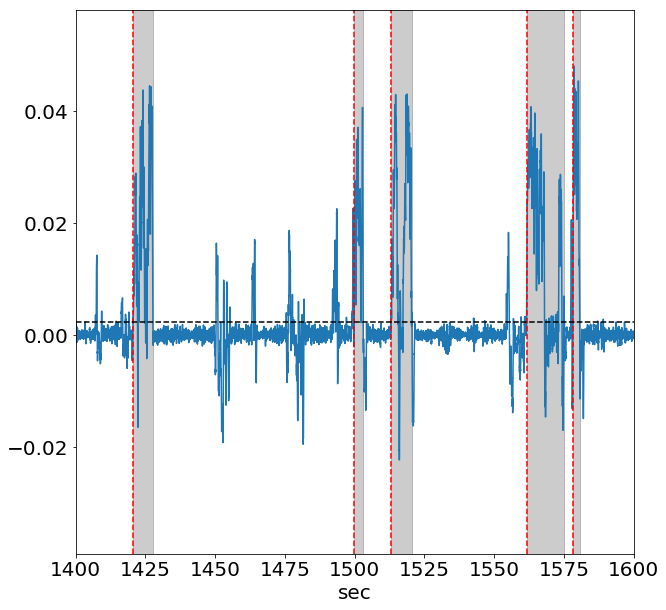

In [20]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac['Y'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1400,1600)
plt.xlabel('sec')
#plt.xlim(808,1000)

In [81]:
# remove bouts that have behavior too close before them
before = 3000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac_interp[bout['start']-before:bout['start']])) < .001]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 53


Text(0.5, 0, 'ms')

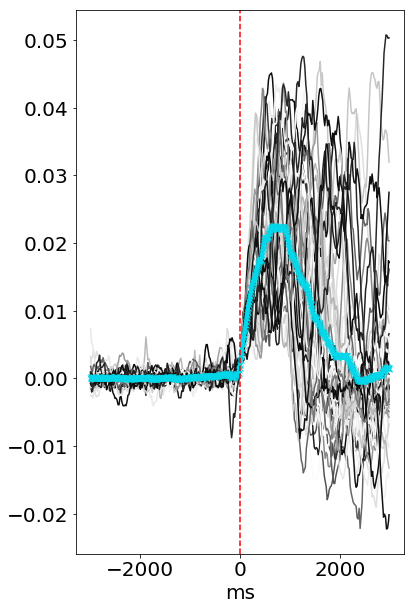

In [25]:
before = 3000 #in ms
after = 3000 # in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac_interp[bout['start']-before:bout['start']+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac_interp[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')

# STOPS

In [37]:
B_THRESHOLD

0.0023378475871640328

In [38]:
resolution

10

In [33]:
# Flip logic?

behavior = 'Y'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

Found 144 bouts


In [49]:
# filter for strong walking before stop

before = 2000 # in ms
before = int(before/resolution)
bouts=[bout for bout in BOUTS if np.mean(fictrac_interp[bout['end']-before:bout['end']]) > .01]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 101


Text(0.5, 0, 'ms')

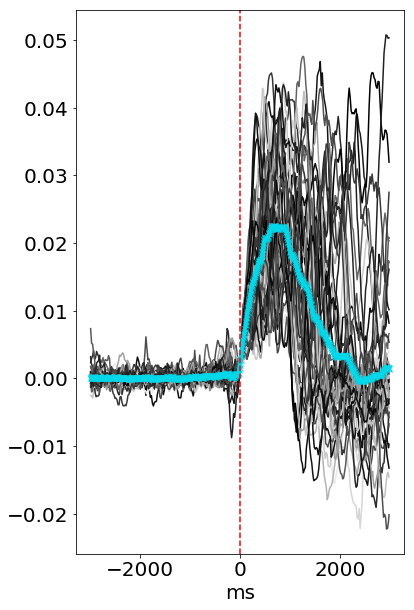

In [82]:
before = 3000 #in ms
after = 3000 # in ms

trigger = 'start'

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac_interp[bout[trigger]-before:bout[trigger]+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac_interp[bout[trigger]-before:bout[trigger]+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')

In [86]:
slice_values = []
for slice_num in range(data.shape[2]):
    print(slice_num)
    xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
    out = interp1d(timestamps[:,slice_num], data[:,:,slice_num,:], axis=-1, bounds_error = False)
    slice_test = out(xnew)

    before = 1000 #in ms
    after = 1000 # in ms
    bout_triggered_slice = [slice_test[:,:,
                                       int((bout[trigger]-before)/10): \
                                       int((bout[trigger]+after)/10)] for bout in bouts][1:-1]

    # quick and dirty scalarization
    temp = np.asarray(bout_triggered_slice)
    before_avg = np.mean(temp[:,:,:,:100],axis=-1)
    after_avg = np.mean(temp[:,:,:,100:],axis=-1)
    out = before_avg - after_avg
    slice_values.append(np.mean(out,axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


In [87]:
slice_values = np.asarray(slice_values)
slice_values_to_save = np.moveaxis(slice_values,0,-1)
slice_values_to_save = ants.from_numpy(slice_values_to_save)
file = os.path.join(root_directory,'fly_21','func_0','20200115_analysis','start_trigger_100pc_reconstr.nii')
ants.image_write(slice_values_to_save,file)

# Subtract start/stop maps

In [91]:
file = os.path.join(root_directory,'fly_21','func_0','20200115_analysis','stop_trigger_10pc_reconstr.nii')
stop10 = bbb.load_numpy_brain(file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 33.38 ms


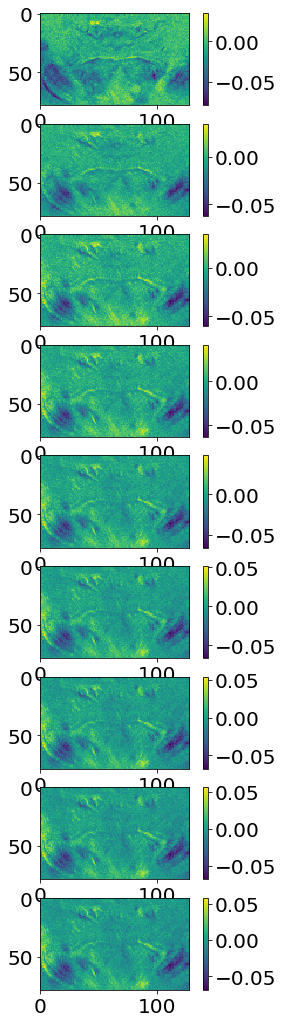

In [115]:
plt.figure(figsize=(5,20))
for i in range(1,10):
    scale = 1/i
    plt.subplot(10,1,i+1)
    plt.imshow(start10[:,:,27].T*scale+stop10[:,:,27].T)
    plt.colorbar()

-0.00020018954073889914


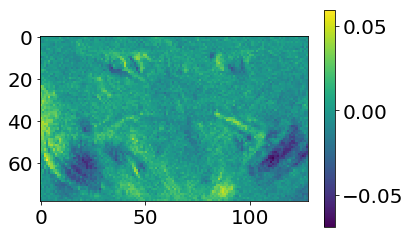

In [129]:
out = start10[:,:,27].T*.1+stop10[:,:,27].T
plt.imshow(out)
plt.colorbar()
print(np.mean(out))

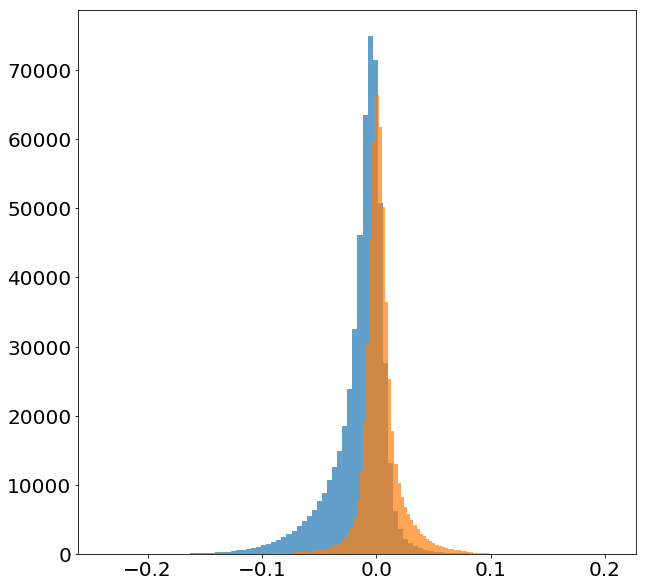

In [136]:
plt.figure(figsize=(10,10))
plt.hist(np.ndarray.flatten(start10),bins=100,alpha=.7);
plt.hist(np.ndarray.flatten(stop10),bins=100,alpha=.7);

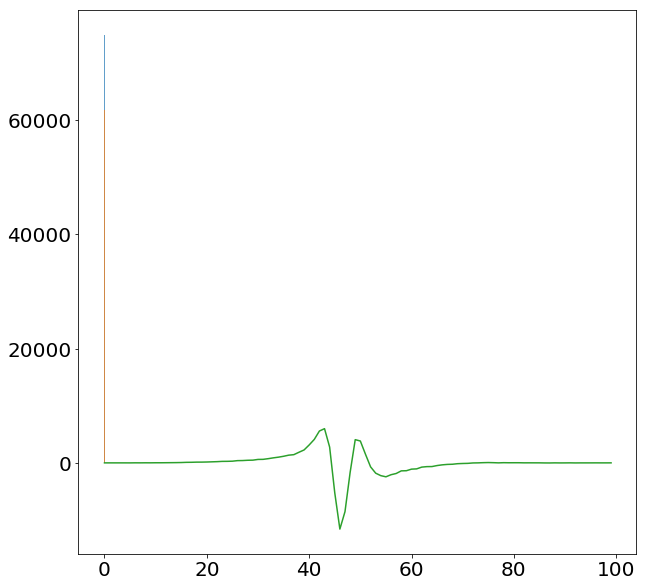

In [169]:
plt.figure(figsize=(10,10))

dist1 = np.ndarray.flatten(start10)*-.6
dist2 = np.ndarray.flatten(stop10)

out1 = plt.hist(dist1,bins=100,alpha=.7)
out2 = plt.hist(dist2,bins=100,alpha=.7)

plt.plot(out2[0]-out1[0])

In [258]:
out_small = out[::10,:]

In [259]:
out_small.shape

(53594, 2)

In [262]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(out_small)
prediction = gmm.predict(out_small)

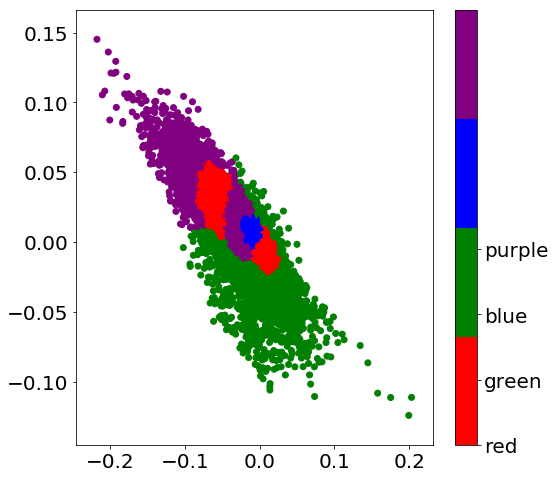

In [263]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = [4,8,12,16,1,4,9,16]
y = [1,4,9,16,4,8,12,3]
label = [0,1,2,3,0,1,2,3]
colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(out_small[:,0],out_small[:,1], c=prediction, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [ ]:
prediction_color = 

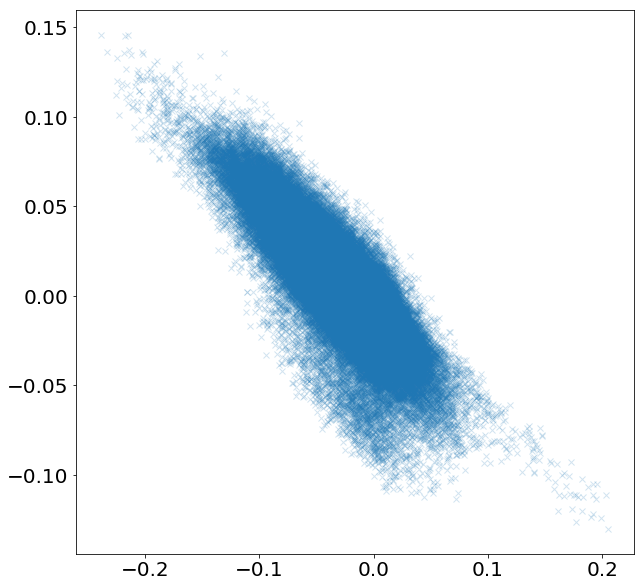

In [266]:
plt.figure(figsize=(10,10))
plt.plot(np.ndarray.flatten(start10),np.ndarray.flatten(stop10),'x',alpha=.2)

In [267]:
temp = -0.1<start10<0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [270]:
temp1 = np.logical_and(start10>= -.1, start10<= 0)
temp2 = np.logical_and(stop10>= -.2, stop10<= -.05)

In [271]:
temp3 = np.logical_and(temp1,temp2)

In [272]:
temp3

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

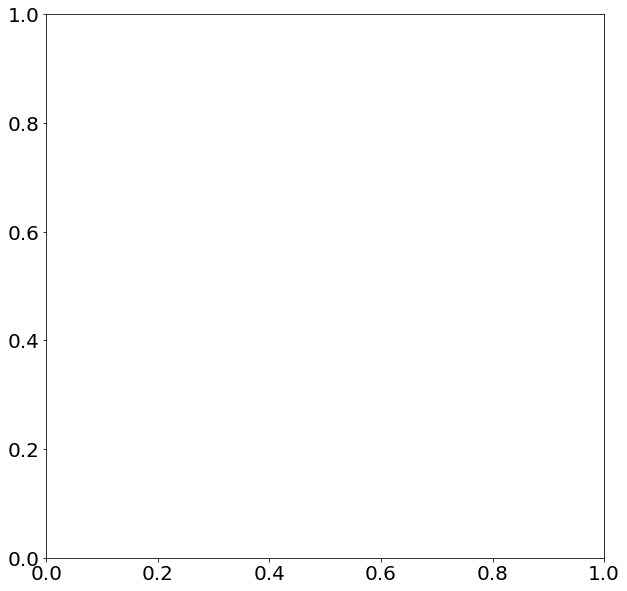

In [251]:
import matplotlib
plt.figure(figsize=(10,10))

colors = ['red','blue']

plt.scatter(np.ndarray.flatten(start10),np.ndarray.flatten(stop10),'x',c=prediction, cmap=matplotlib.colors.ListedColormap(colors))

In [230]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

In [ ]:
np.ndarray.flatten(start10)

In [214]:
# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

In [221]:
out = np.vstack((np.ndarray.flatten(start10),np.ndarray.flatten(stop10))).T

In [241]:
out.shape

(535936, 2)

In [215]:
X.shape

(1000, 2)

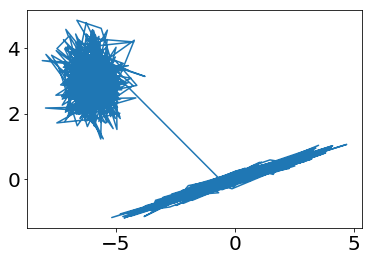

In [217]:
plt.plot(X[:,0],X[:,1])

In [246]:
len(prediction)

535936

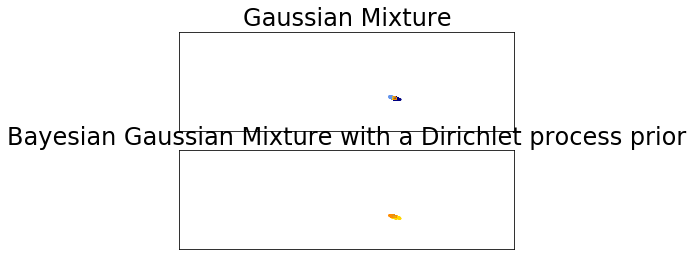

In [240]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
X=out

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

In [226]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

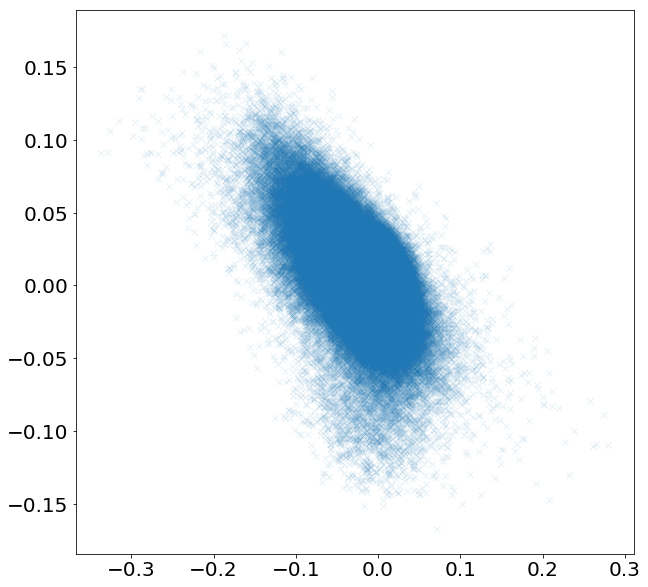

In [210]:
plt.figure(figsize=(10,10))
plt.plot(np.ndarray.flatten(start100),np.ndarray.flatten(stop100),'x',alpha=.1)

In [196]:
out = start10>.1

TypeError: only size-1 arrays can be converted to Python scalars

In [197]:
out.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [184]:
Y = start10.reshape(-1)
X = stop10.reshape(-1)
A = np.vstack([X, np.ones(len(X))]).T
out = np.linalg.lstsq(A, Y)

In [185]:
out

(array([-1.17888162, -0.0099428 ]),
 array([110.45243347]),
 2,
 array([732.08144453,  12.15301569]))

In [179]:
out[1]

array([160.95912993])

In [178]:
out[0]

array([[-1.30528585]])

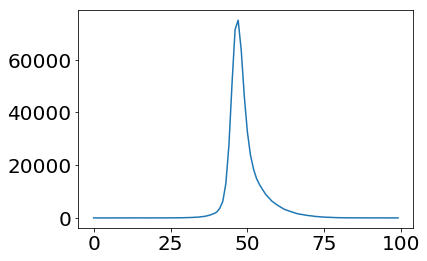

In [170]:
plt.plot(out1[0])

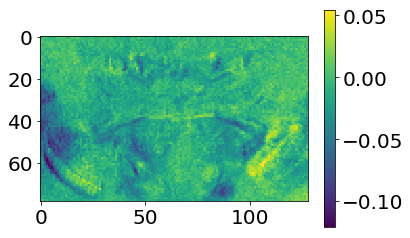

In [127]:
plt.imshow(start10[:,:,27].T)
plt.colorbar()

In [123]:
for i in np.arange(.1,.3,.01):
    print(i, np.mean(stop10+(start10*i)))

0.1 0.002247765438321894
0.11 0.0021050096896656958
0.12 0.0019622539410094958
0.13 0.0018194981923532953
0.13999999999999999 0.0016767424436970949
0.14999999999999997 0.0015339866950408957
0.15999999999999998 0.0013912309463846952
0.16999999999999998 0.0012484751977284954
0.17999999999999997 0.001105719449072295
0.18999999999999995 0.0009629637004160957
0.19999999999999996 0.0008202079517598957
0.20999999999999996 0.0006774522031036954
0.21999999999999995 0.0005346964544474965
0.22999999999999995 0.00039194070579129646
0.23999999999999994 0.00024918495713509655
0.24999999999999992 0.0001064292084788963
0.2599999999999999 -3.6326540177302856e-05
0.2699999999999999 -0.00017908228883350258
0.2799999999999999 -0.0003218380374897027
0.2899999999999999 -0.00046459378614590246


In [118]:
np.arange(2,10,5)

array([2, 7])

In [102]:
def norm_brain(brain):
    out = (brain - np.mean(brain))/np.mean(brain)
    return out

In [273]:
out = temp3.astype('float32')
slice_values_to_save = ants.from_numpy(out)
file = os.path.join(root_directory,'fly_21','func_0','20200115_analysis','10pc_start_fancy2.nii')
ants.image_write(slice_values_to_save,file)

In [205]:
np.max(out)

1.0

In [ ]:
(start10)*-.6)-.002

In [94]:
np.mean(stop10)

0.0036753229248838934

In [92]:
stop10.shape

(128, 79, 53)

# TURNS - Revisit 2D Velocity

In [ ]:
plt.plot(fictrac['Y'], fictrac['Z'])

In [ ]:
plt.figure(figsize=(10,10))
norm = mpl.colors.LogNorm()

#plt.subplot(221)
plt.hist2d(fictrac['Y'],fictrac['Z'],bins=100,cmap='Blues',norm=norm);
#plt.ylim(-200,200)
#plt.xlim(-10,10)
plt.title('Full space')

In [ ]:
behavior = 'Y'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))